In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import pandas as pd
import numpy as np
matplotlib.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import KFold
import copy

c:\Users\mdzak\anaconda3\envs\fyp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import CSV and merge with drugs

In [2]:
selected_dim = 256
dimension = pd.read_csv('../results/results' + str(selected_dim) + 'D_latent_space_gene_exp.tsv',sep='\t')
cell_line_name = pd.read_csv('../results_clean/cell_line_name.csv')
gdsc_drug = pd.read_csv('../results_clean/gdsc_drug_nodash.csv')
dimension.drop(columns=['Unnamed: 0'], inplace=True)
gdsc_drug.drop(columns=['Unnamed: 0'], inplace= True)
dimension['CELL_LINE_NAME'] = cell_line_name['CELL_LINE_NAME']
dimension_w_drug = pd.merge(dimension, gdsc_drug, on='CELL_LINE_NAME')
dimension_w_drug.drop(columns=['CELL_LINE_NAME'],inplace=True)
# dimension_w_drug = pd.get_dummies(dimension_w_drug, columns=['DRUG_NAME'])

In [3]:
dimension_w_drug = dimension_w_drug.sample(frac=1, random_state=33).reset_index(drop=True)
dimension_w_drug

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,LN_IC50,DRUG_NAME
0,9.580048e-07,5.955522e-06,0.000014,0.000014,0.000001,1.570985e-05,-0.000010,0.000007,3.700359e-07,0.000015,...,-0.000007,-4.242860e-07,0.000013,-3.849741e-05,0.000005,-0.000002,8.483571e-06,-0.000007,2.686879,LGK974
1,4.754656e-06,6.616774e-06,0.000025,0.000009,-0.000004,1.614111e-05,-0.000016,0.000008,1.983518e-05,0.000018,...,-0.000017,-5.611180e-07,0.000008,3.470145e-05,-0.000025,-0.000009,9.388927e-06,-0.000017,5.515893,5-azacytidine
2,8.859231e-06,9.899239e-06,0.000039,0.000022,-0.000003,2.657529e-05,-0.000026,0.000012,2.709077e-05,0.000030,...,-0.000035,-1.303582e-06,0.000014,1.111220e-05,-0.000027,-0.000007,1.565055e-05,-0.000025,2.400499,Sorafenib
3,2.740748e-06,2.525117e-06,0.000013,0.000001,-0.000004,3.479236e-06,-0.000007,0.000005,1.858863e-05,0.000010,...,-0.000021,3.242361e-07,-0.000002,5.823753e-05,-0.000034,-0.000007,1.567669e-06,-0.000011,3.499021,PRT062607
4,7.027902e-06,8.740029e-06,0.000034,0.000017,-0.000003,2.332633e-05,-0.000024,0.000011,2.547213e-05,0.000028,...,-0.000028,-1.107897e-06,0.000012,2.180096e-05,-0.000028,-0.000007,1.383049e-05,-0.000025,2.639762,AZD5438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157613,5.458063e-06,5.013088e-06,0.000020,0.000007,-0.000004,1.177480e-05,-0.000012,0.000007,1.793895e-05,0.000016,...,-0.000020,-3.275805e-07,0.000006,4.242635e-05,-0.000027,-0.000010,7.394970e-06,-0.000014,2.482369,AGK2
157614,9.209887e-06,6.249217e-06,0.000018,0.000010,-0.000004,1.433584e-05,-0.000007,0.000007,9.192792e-06,0.000015,...,-0.000010,-5.935721e-07,0.000011,2.720339e-05,-0.000013,-0.000011,1.194827e-05,-0.000011,2.919147,Cisplatin
157615,4.024799e-06,1.372068e-07,0.000011,0.000006,-0.000001,-5.288073e-08,-0.000005,0.000003,1.809493e-05,0.000009,...,-0.000028,7.446235e-07,-0.000008,4.290721e-05,-0.000034,-0.000002,9.718482e-08,-0.000009,4.440038,Serdemetan
157616,7.814031e-06,8.357787e-06,0.000035,0.000021,-0.000001,2.442457e-05,-0.000024,0.000010,2.252506e-05,0.000027,...,-0.000028,-9.688630e-07,0.000013,-9.838519e-08,-0.000020,-0.000003,1.485326e-05,-0.000022,3.617427,ABT737


### Seperate continuous and categorical columns

In [4]:
cat_cols = ['DRUG_NAME']
cont_cols = dimension_w_drug.drop(columns=['DRUG_NAME', 'LN_IC50']).columns
label_cols = ['LN_IC50']

In [5]:
cont_cols

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '246', '247', '248', '249', '250', '251', '252', '253', '254', '255'],
      dtype='object', length=256)

In [6]:
cat_cols

['DRUG_NAME']

### Categorify

In [7]:
for cat in cat_cols:
    dimension_w_drug[cat] = dimension_w_drug[cat].astype('category')

In [8]:
dimension_w_drug.dtypes

0             float64
1             float64
2             float64
3             float64
4             float64
               ...   
253           float64
254           float64
255           float64
LN_IC50       float64
DRUG_NAME    category
Length: 258, dtype: object

In [9]:
dimension_w_drug['DRUG_NAME'].head()

0           LGK974
1    5-azacytidine
2        Sorafenib
3        PRT062607
4          AZD5438
Name: DRUG_NAME, dtype: category
Categories (286, object): ['123138', '123829', '150412', '5-Fluorouracil', ..., 'Zoledronate', 'alpha-lipoic acid', 'ascorbate (vitamin C)', 'glutathione']

In [10]:
dimension_w_drug['DRUG_NAME'].cat.categories

Index(['123138', '123829', '150412', '5-Fluorouracil', '5-azacytidine',
       '50869', '615590', '630600', '667880', '720427',
       ...
       'WZ4003', 'Wee1 Inhibitor', 'Wnt-C59', 'XAV939', 'YK-4-279', 'ZM447439',
       'Zoledronate', 'alpha-lipoic acid', 'ascorbate (vitamin C)',
       'glutathione'],
      dtype='object', length=286)

In [11]:
drug_name = dimension_w_drug['DRUG_NAME'].cat.codes.values

In [12]:
cats = np.stack([drug_name],1)
cats = torch.tensor(cats, dtype=torch.int64)

In [13]:
cats

tensor([[146],
        [  4],
        [237],
        ...,
        [235],
        [ 16],
        [168]])

### Continuous variables to tensor

In [14]:
conts = np.stack([dimension_w_drug[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts

tensor([[ 9.5800e-07,  5.9555e-06,  1.3503e-05,  ..., -2.1892e-06,
          8.4836e-06, -7.1867e-06],
        [ 4.7547e-06,  6.6168e-06,  2.4625e-05,  ..., -8.5705e-06,
          9.3889e-06, -1.7378e-05],
        [ 8.8592e-06,  9.8992e-06,  3.9467e-05,  ..., -6.7398e-06,
          1.5651e-05, -2.5286e-05],
        ...,
        [ 4.0248e-06,  1.3721e-07,  1.0642e-05,  ..., -2.4570e-06,
          9.7185e-08, -9.0279e-06],
        [ 7.8140e-06,  8.3578e-06,  3.5009e-05,  ..., -3.4043e-06,
          1.4853e-05, -2.2241e-05],
        [ 7.3776e-06,  8.5856e-06,  3.5372e-05,  ..., -3.1254e-06,
          1.4711e-05, -2.6975e-05]])

### Labels to tensor

In [15]:
labels = np.stack([dimension_w_drug[col].values for col in label_cols], 1)
labels = torch.tensor(labels, dtype=torch.float)
labels

tensor([[2.6869],
        [5.5159],
        [2.4005],
        ...,
        [4.4400],
        [3.6174],
        [4.5057]])

### Embedding size

In [16]:
cat_szs = [len(dimension_w_drug[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(286, 50)]

### Define model

In [17]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [18]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [19]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(286, 50)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=306, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Loss and Optimizer Function

In [20]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
torch.cuda.get_device_name(0) # Get name device with ID '0'

'NVIDIA GeForce RTX 3060'

### Perform train/test splits

In [22]:
batch_size = conts.shape[0]
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = labels[:batch_size-test_size]
y_test = labels[batch_size-test_size:batch_size]

In [26]:
con_train.shape

torch.Size([126095, 256])

### Train model

In [27]:
import time
start_time = time.time()

epochs = 500
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(loss_fn(y_pred, y_train)) # RMSE
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 3.99527407
epoch:  26  loss: 3.42042565
epoch:  51  loss: 3.07258630
epoch:  76  loss: 2.67432499
epoch: 101  loss: 2.29724717
epoch: 126  loss: 2.08775568
epoch: 151  loss: 1.98708105
epoch: 176  loss: 1.91374063
epoch: 201  loss: 1.85513067
epoch: 226  loss: 1.81236827
epoch: 251  loss: 1.77801180
epoch: 276  loss: 1.75235283
epoch: 301  loss: 1.72746027
epoch: 326  loss: 1.70683277
epoch: 351  loss: 1.68594325
epoch: 376  loss: 1.67064583
epoch: 401  loss: 1.65741646
epoch: 426  loss: 1.64645028
epoch: 451  loss: 1.63461578
epoch: 476  loss: 1.61951208
epoch: 500  loss: 1.61280465

Duration: 613 seconds


### Plot loss function

Text(0.5, 0, 'epoch')

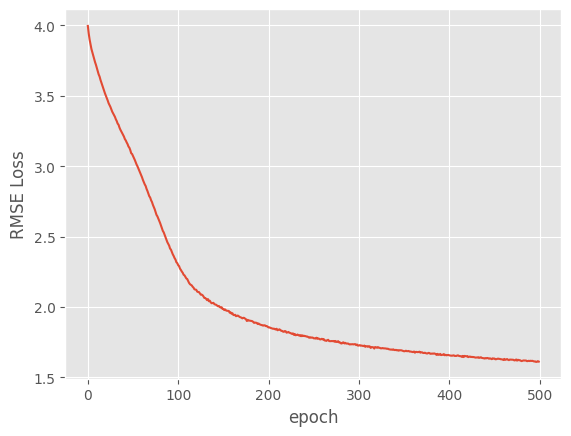

In [28]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')

### Validate Model

In [29]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(loss_fn(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 1.61999047


In [30]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(100):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.  -1.8097  -0.0142   1.7955
 2.   3.9496   1.1932   2.7564
 3.   4.4884   2.3768   2.1116
 4.   4.8820   5.8819   0.9999
 5.   1.8057   3.6806   1.8749
 6.   2.5452   5.3496   2.8044
 7.   4.2092   4.4454   0.2362
 8.   3.6395   3.5117   0.1278
 9.   2.4176  -0.0613   2.4790
10.   0.8356   0.3543   0.4813
11.   4.5686   4.5224   0.0463
12.   4.8114   4.5157   0.2957
13.   4.5604   6.0162   1.4558
14.   4.9276   5.7954   0.8678
15.   5.2811   4.7382   0.5429
16.   0.6779  -0.0545   0.7324
17.   3.5948   2.1559   1.4389
18.  10.0052   8.0332   1.9719
19.   4.4096   5.4961   1.0865
20.   1.9432   4.7903   2.8472
21.   2.4105  -0.1294   2.5399
22.   2.4421   1.2184   1.2236
23.  -0.8609   0.8689   1.7297
24.   1.6690   1.0359   0.6331
25.   1.4530   1.9203   0.4673
26.   5.1484   4.8219   0.3265
27.   3.2525   4.1070   0.8545
28.   6.6869   7.2403   0.5534
29.   1.9562   2.6463   0.6901
30.   1.0827  -0.1525   1.2352
31.   1.9069   2.1100   0.2031
32.   4.